In [1]:
from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from numpy.linalg import lstsq

import matplotlib as mpl
mpl.rcParams["image.interpolation"] = 'none'

In [2]:
# For plotting

def compute_bounds(mu, sig, n_sigma = 3):
    """
    Use mean and standard deviation vectors to compute upper and lower bounds.
    """
    upper = mu + n_sigma * np.sqrt(np.abs(sig))
    lower = mu - n_sigma * np.sqrt(np.abs(sig))
    
    return upper, lower

In [3]:
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig1_fg.hdf5", "r")

#get the data for plotting the sd image
dataCh0 = np.array(f1['panel_fg']['dataCh0'])
roimask = np.array(f1['panel_fg']['roimask'])
x_zoom = np.array(f1['panel_fg']['x_zoom'])

f1.close()

C:\Users\alv5645\AppData\Local\Temp/ipykernel_20412/1871873755.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  dataCh0 = np.array(f1['panel_fg']['dataCh0'])
C:\Users\alv5645\AppData\Local\Temp/ipykernel_20412/1871873755.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  roimask = np.array(f1['panel_fg']['roimask'])
C:\Users\alv5645\AppData\Local\Temp/ipykernel_20412/1871873755.py:7: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  x_zoom = np.array(f1['panel_fg']['x_zoom'])


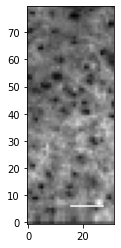

In [4]:
#calculate std
std = np.std(dataCh0, axis=2)  # standard deviation across time
avg_projection = np.mean(dataCh0, axis=2)

#plot the standard deviation image for this field

plt.imshow(std[:80,:], cmap='Greys_r', origin='lower')

plt.axhline(y=6, xmin=14/27.5, xmax=24/27.5, color='white')



# Get snippets

In [5]:
#pull this data from the hdf5 file
data_df = pd.read_hdf('Data/Fig1_fg.hdf5', '/panel_fg/snippet_data_df')

# Get model responses from GP (Bct)

In [6]:
#pull this data from the hdf5 file
results = pd.read_hdf('Data/Fig1_fg.hdf5', '/panel_fg/gp_results_df')
results_ds = pd.read_hdf('Data/Fig1_fg.hdf5', '/panel_fg/dprime_results_df')

In [7]:
#select a specific ROI to plot

center_px_id = 631  #ROIs used in Figure: [208, 316, 631, 916, 1304, 1536, 2009,]
color_id = 6
results_roi = results.loc[results['center_pixel_id']==center_px_id]
results_ds_roi = results_ds.loc[results_ds['center_pixel_id']==center_px_id]

In [8]:
#pull out the relevant data
mu = results_roi['mu'].values[0]
x_predict = results_roi['x_predict'].values[0]
sig = results_roi['sig'].values[0]
sig_outer = results_roi['sig_outer'].values[0]
x_predict_t = np.copy(x_predict[::mu.shape[0],:])

#get SD of responses for normalization
rois = results_roi['roi_list'].values[0]

#get the average response of these rois (averaged over binned time of the traces) that was used for GP modeling
df_GP_rois = data_df.loc[rois].groupby(
    ['directions', 'lengths', 'trial_nums', 'time_resampled']).mean()

df_GP_rois = df_GP_rois.reset_index()
df_GP_rois = df_GP_rois.set_index(['directions', 'lengths', 'time_bin'])

df_GP_rois_average = df_GP_rois.groupby(['directions', 'lengths', 'time_bin']).mean()

mean_of_trace = df_GP_rois['y'].mean()
sd_of_trace = df_GP_rois['y'].std()

#normalize GP predictions for plotting
mu1 = results_ds_roi['mu1'].values[0]
mu2 = results_ds_roi['mu2'].values[0]

mu1_norm = mu1/sd_of_trace
mu2_norm = mu2/sd_of_trace

<Figure size 1080x432 with 0 Axes>

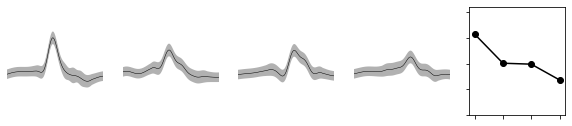

In [9]:
#plot all the directions and the d' for this ROI
plt.figure(figsize=(15, 6))

directions = [0, 180]
lengths = [100, 150]

colors1 = ['peru', 'lightseagreen', 'peru', 'lightseagreen', 'peru', 'lightseagreen']
colors2 = ['blue', 'black', 'green', 'magenta', 'purple', 'orange']
# colors3 = cm.get_cmap('Dark2')

n_conditions = mu.shape[0]
gp_index = [0, 2, 1, 3, 5, 4]
gp_index = [3, 0, 5, 2, 4, 1]

plt.figure(figsize=(10, 2))
# plt.title(str(d_prime))
color = color_id/(7)
index = 1
# for length in lengths:
#     for direction in directions:
order_index = [1, 4, 2, 3]
for index in [1,2,3,4]:
        ax1 = plt.subplot(1,5,order_index[index-1])
        upper, lower = compute_bounds(mu[gp_index[index-1],:]/sd_of_trace, sig[gp_index[index-1],:]/sd_of_trace, n_sigma = 3, )
        plt.fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.3, )
        plt.plot(x_predict_t[:,0], mu[gp_index[index-1],:]/sd_of_trace, color='k', lw=0.5)
        
        plt.axis('off')
        axes = plt.gca()
        axes.set_xlim([0.5, 2.])
        axes.set_ylim([-2, 3])
#         plt.legend(loc='upper left')


ax1 = plt.subplot(1,5,5)    
# lengths = ['100', '150', '300']

columns = ['origin', 'mid1', 'mid2', 'term']
values = [mu2_norm[0], mu2_norm[1], mu1_norm[1], mu1_norm[0]]

plt.plot(columns, values, color='k', marker='o')

axes = plt.gca()
axes.set_ylim([0,2.1])
axes.set_xlim([-0.2,3.2])
# axes.axhline(linestyle='dotted', color='k')
# Turn off tick labels
axes.set_yticklabels([])
axes.set_xticklabels([])
        
plt.show()

# Supplementary Figure 1

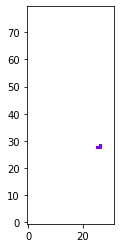

In [10]:
#show where these pixels are

roi_list_all = [results_roi['roi_list'].values[0]]
for i, rois in enumerate(roi_list_all):
    dsmap0 = roimask*(-1)
    xlength = dsmap0.shape[0]
    ylength = dsmap0.shape[1]
    for x in range(xlength):
        for y in range(ylength):  
            if dsmap0[x,y] in rois:
                dsmap0[x,y] = i+1
            elif dsmap0[x,y]>0:
                dsmap0[x,y] = np.nan
            else:
                dsmap0[x,y] = np.nan

    fig=plt.figure()
    plt.imshow(dsmap0[:80,:], cmap='rainbow', origin='lower', vmin=1, vmax=8)
plt.show()

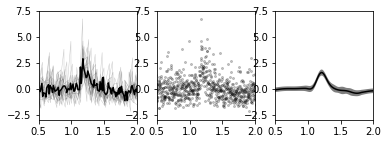

In [11]:
#plot the individual trials and compare GP to binned average
#Fig. S1 shows ROI number 631
direction = 180
index = 3

ytop=7.5
ybottom=-3

fig = plt.figure(figsize=(6,2))

ax1 = plt.subplot(1,3,1)
trial_list = df_GP_rois['trial_nums'].loc[direction,100].unique()
offset=0
for trial in trial_list:
    plt.plot(df_GP_rois[df_GP_rois['trial_nums']==trial]['x_t'], 
             df_GP_rois[df_GP_rois['trial_nums']==trial]['y']/sd_of_trace, alpha=0.2, color='k', linewidth=0.5)  
plt.plot(df_GP_rois_average['y'].loc[direction, 100]/sd_of_trace, color='k')
ax1.set_ylim([ybottom, ytop])
ax1.set_xlim([0.5, 2.0])


ax2 = plt.subplot(1,3,2)
trial_list = df_GP_rois['trial_nums'].loc[direction,100].unique()
offset=0
for trial in trial_list:
    plt.scatter(df_GP_rois[df_GP_rois['trial_nums']==trial]['x_t'], 
                df_GP_rois[df_GP_rois['trial_nums']==trial]['y']/sd_of_trace, color='k', alpha=0.2, s=4) # 
ax2.set_ylim([ybottom, ytop])
ax2.set_xlim([0.5, 2.0])


ax3 = plt.subplot(1,3,3)
# plt.plot(df_GP_rois_average['y'].loc[direction, 100]/sd_of_trace, color='grey')
upper, lower = compute_bounds(mu[index,:]/sd_of_trace, sig[index,:]/sd_of_trace, n_sigma = 3)
plt.fill_between(x_predict_t[:,0], upper, lower, facecolor = 'k', alpha = 0.5)
plt.plot(x_predict_t[:,0], mu[index,:]/sd_of_trace, color='k')
ax3.set_ylim([ybottom, ytop])
ax3.set_xlim([0.5, 2.0])


plt.show()

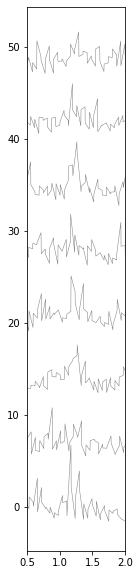

In [12]:
#plot the individual trials for Fig S1
direction = 180
index = 3

ytop=7.5
ybottom=-3

fig = plt.figure(figsize=(6,10))

ax1 = plt.subplot(1,3,1)
trial_list = df_GP_rois['trial_nums'].loc[direction,100].unique()
offset=7
i = 0
for trial in trial_list[5:13]:
    plt.plot(df_GP_rois[df_GP_rois['trial_nums']==trial]['x_t'], 
             df_GP_rois[df_GP_rois['trial_nums']==trial]['y']/sd_of_trace+offset*i, alpha=0.5, color='k', linewidth=0.5)  
    i+=1
# ax1.set_ylim([ybottom, ytop])
ax1.set_xlim([0.5, 2.0])


plt.show()

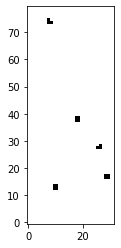

In [13]:
# get all example pixels and plot on the map

center_pixels = [208, 316, 631, 916, 1304, 1536, 2009,]
roi_list_all = []
for px in center_pixels:
    results_roilists = results.loc[results['center_pixel_id']==px]['roi_list'].values[0]
    roi_list_all.append(results_roilists)

dsmap0 = roimask*(-1)*1000
xlength = dsmap0.shape[0]
ylength = dsmap0.shape[1]

for i, rois in enumerate(roi_list_all):

    for x in range(xlength):
        for y in range(ylength):  
            if dsmap0[x,y]/1000 in rois:
                dsmap0[x,y] = i+1
#             elif dsmap0[x,y]<0:
#                 dsmap0[x,y] = -1
#             else:
#                 dsmap0[x,y] = np.nan

dsmap0_final = np.where(dsmap0>999, np.nan, dsmap0)
dsmap0_final = np.where(dsmap0_final<0, np.nan, dsmap0_final)
#     fig=plt.figure()
plt.imshow(dsmap0_final[:80,:], origin='lower', vmin=8, vmax=9, cmap='Greys_r') #cmap='Dark2', 


# Map of d-prime for this field

In [14]:
#remove non-responsive pixels, where the model failed to detect a large change in response

dsi_results = results_ds.set_index('center_pixel_id')

all_mu = results[['center_pixel_id', 'mu']]

mu_std = np.zeros((all_mu.shape[0],6))

for i, mu_i in enumerate(all_mu['mu']):
    mu_std[i] = np.std(mu_i[:, 40:100], axis=1)
mu_std_max = np.amax(mu_std, axis=1)
dsi_results['mu_std_max'] = mu_std_max

threshold = 0.1
dsi_results = dsi_results[dsi_results['mu_std_max']>threshold]
dsi_results.pop('mu_std_max')

dsi_results['dsi_100'] = dsi_results['d_prime'].apply(lambda x: x[0])
dsi_results['dsi_150'] = dsi_results['d_prime'].apply(lambda x: x[1])
dsi_results['dsi_300'] = dsi_results['d_prime'].apply(lambda x: x[2])

std_100 = dsi_results['dsi_100'].std()
std_150 = dsi_results['dsi_150'].std()
std_300 = dsi_results['dsi_300'].std()

mean_dsi = dsi_results['d_prime'].mean()

std_dsi = np.array([std_100, std_150, std_300])

std_top = mean_dsi + std_dsi
std_bottom = mean_dsi - std_dsi

In [15]:
cm = plt.get_cmap('BrBG') #sns.diverging_palette(20, 220, n=50)
cm.set_bad(color='lightgrey')
color_range = 100

C:\Users\alv5645\AppData\Local\Temp/ipykernel_20412/1816203656.py:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("BrBG").copy()
  cm.set_bad(color='lightgrey')


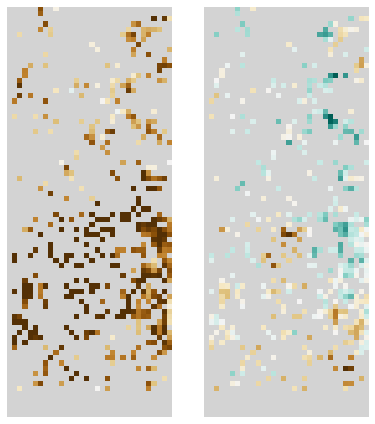

In [16]:
#plot D-prime across the field (Panel g)
roi_list = dsi_results.index.to_frame(index=False)['center_pixel_id'].unique()

#make map for 100 length stimulus
dsmap0 = roimask*(-1)
xlength = dsmap0.shape[0]
ylength = dsmap0.shape[1]
for x in range(xlength):
    for y in range(ylength):  
        if dsmap0[x,y] in roi_list:
            roi_index = int(dsmap0[x, y])
            dsmap0[x,y] = dsi_results.loc[roi_index, 'dsi_100']
        else:
            dsmap0[x,y] = np.nan

            
#make map for 150 length stimulus
dsmap1 = roimask*(-1)
xlength = dsmap1.shape[0]
ylength = dsmap1.shape[1]
for x in range(xlength):
    for y in range(ylength):  
        if dsmap1[x,y] in roi_list:
            roi_index = int(dsmap1[x, y])
            dsmap1[x,y] = dsi_results.loc[roi_index, 'dsi_150']
        else:
            dsmap1[x,y] = np.nan

            

fig = plt.figure(figsize=(10, 10))

crop = 80

ax0 = fig.add_subplot(1,3,1)
plt.imshow(dsmap0[:crop,:], cmap=cm, vmin=-1*color_range, vmax=color_range, origin='lower') #'RdYlBu'
# cb = plt.colorbar()
# ax1.set_ylim([10, 48])
# ax1.set_xlim([18, 45])
plt.axis('off')

ax1 = fig.add_subplot(1,3,2)
plt.imshow(dsmap1[:crop,:], cmap=cm, vmin=-1*color_range, vmax=color_range, origin='lower') #'RdYlBu'
# cb = plt.colorbar()
# ax1.set_ylim([10, 48])
# ax1.set_xlim([18, 45])
plt.axis('off')

plt.show()